# CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

# Code:

#### Imports

In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
import datetime

#### Hyperparameters

In [3]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.0

#### Loading the data

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170508288/170498071 [==============================] - 3s 0us/step


In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [7]:
# Data normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
sample_image = X_train[100]
sample_image.shape

(32, 32, 3)

In [9]:
from numpy import expand_dims
from matplotlib import pyplot

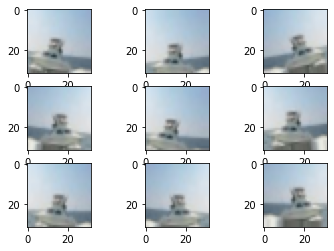

In [10]:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
sample_images = expand_dims(sample_image, 0)

# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# prepare iterator
it = datagen.flow(sample_images, batch_size=1)
# generate sample images and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    image = batch[0]
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
pyplot.show()

#### Code blocks

In [12]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.0):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
        if dropout_rate > 0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        temp = concat

    return temp

# Transition Block
def transition(input, num_filter = 12, dropout_rate = 0.0):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
    if dropout_rate > 0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

# Output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    MaxPooling = layers.MaxPooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(MaxPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

#### Model

In [13]:
num_filter = 12
dropout_rate = 0
l = 12

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(32, (3,3), use_bias=False, padding='same')(input)

First_Block = denseblock(First_Conv2D,10, dropout_rate)
First_Transition = transition(First_Block, 64, dropout_rate)

Second_Block = denseblock(First_Transition, 10, dropout_rate)
Second_Transition = transition(Second_Block, 32, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, 32, dropout_rate)

Last_Block = denseblock(Third_Transition, num_filter, dropout_rate)
output = output_layer(Last_Block)

In [14]:
# https://arxiv.org/pdf/1608.06993.pdf
# from IPython.display import IFrame, YouTubeVideo
# YouTubeVideo(id='-W6y8xnd--U', width=600)

In [15]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

In [16]:
print(len(model.layers))

211


In [17]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [18]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
def model_with_augmentation(X_train, y_train, X_test, y_test, actual_batch_size, actual_step_size, actual_epochs):
    '''
    model using data augmentation

    '''

    # create data generator
    train_datagen = ImageDataGenerator(rotation_range=15,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 horizontal_flip=True)
    
    # prepare iterator
    itr_train = train_datagen.flow(X_train, y_train, batch_size=actual_batch_size)
    
    # fit model
    total_steps = X_train.shape[0] // actual_batch_size

    print('Start....')
    history = model.fit(itr_train,
                        steps_per_epoch=total_steps,
                        epochs=actual_epochs,
                        validation_data=(X_test, y_test),
                        verbose=1,
                        callbacks=tensorboard_callback)

In [ ]:
# entry point, run the test harness
model_with_augmentation(X_train, y_train, X_test, y_test, 60, 60, 60)

Start....
Epoch 1/60
833/833 [==============================] - 79s 95ms/step - loss: 0.1996 - accuracy: 0.9297 - val_loss: 0.5084 - val_accuracy: 0.8566
Epoch 2/60
833/833 [==============================] - 80s 96ms/step - loss: 0.1970 - accuracy: 0.9313 - val_loss: 0.4440 - val_accuracy: 0.8719
Epoch 3/60
833/833 [==============================] - 80s 96ms/step - loss: 0.1935 - accuracy: 0.9311 - val_loss: 0.4779 - val_accuracy: 0.8639
Epoch 4/60
833/833 [==============================] - 80s 96ms/step - loss: 0.1918 - accuracy: 0.9320 - val_loss: 0.3764 - val_accuracy: 0.8843
Epoch 5/60
833/833 [==============================] - 80s 96ms/step - loss: 0.1904 - accuracy: 0.9323 - val_loss: 0.5615 - val_accuracy: 0.8357
Epoch 6/60
833/833 [==============================] - 80s 96ms/step - loss: 0.1857 - accuracy: 0.9350 - val_loss: 0.3820 - val_accuracy: 0.8892
Epoch 7/60
833/833 [==============================] - 80s 97ms/step - loss: 0.1844 - accuracy: 0.9342 - val_loss: 0.3462 - val

In [26]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 6s 18ms/step - loss: 0.4124 - accuracy: 0.8935
Test loss: 0.41235965490341187
Test accuracy: 0.8934999704360962


In [27]:
%tensorboard --logdir logs/fit

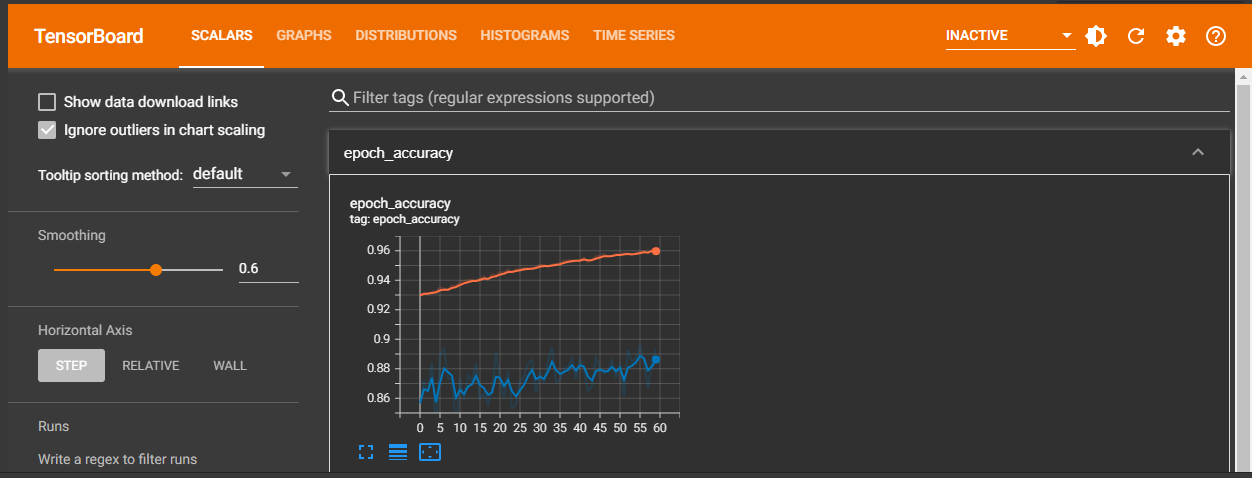

In [34]:
# Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.
# Reference Link for Pretty table:  https://pypi.org/project/prettytable/
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Epochs", "Best Train Accuracy ", "Best Test Accuracy"]

x.add_row([60, round(0.9611, 2), round(0.8956, 2)])

print(x)

+--------+----------------------+--------------------+
| Epochs | Best Train Accuracy  | Best Test Accuracy |
+--------+----------------------+--------------------+
|   60   |         0.96         |        0.9         |
+--------+----------------------+--------------------+


#### Observation:
- Although Dropouts are not allowed, this bias-variance trade-off is pretty good.
- Within 60 epochs we got 96% train accuracy and 90% test accuracy.